Mounted at /content/drive
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Fitting 3 folds for each of 15 candidates, totalling 45 fits

==== Train Evaluation ====
Train Accuracy: 0.8522
Train ROC AUC:  0.9357
Accuracy @ 0.50 threshold: 0.8280
ROC AUC:             0.8652

Classification Report:
              precision    recall  f1-score   support

         0.0       0.84      0.81      0.83        47
         1.0       0.81      0.85      0.83        46

    accuracy                           0.83        93
   macro avg       0.83      0.83      0.83        93
weighted avg       0.83      0.83      0.83        93

Best threshold by brute-force: 0.48 → Accuracy: 0.8280

Classification Report @ best threshold:
              precision    recall  f1-score   support

         0.0       0.84      0.81      0.83        47
         1.0       0.81      0.85      0.83        46

    accuracy                           0.83        93
   macro avg       0.83      0.83      0.83        

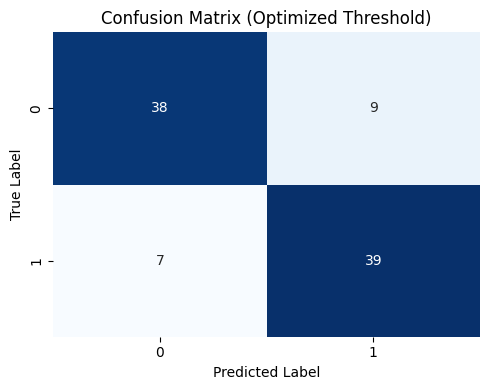


XGBoost best parameters:
{'colsample_bytree': np.float64(0.6624074561769746), 'learning_rate': np.float64(0.041198904067240534), 'max_depth': 5, 'n_estimators': 187, 'subsample': np.float64(0.7334834444556088)}

Random Forest best parameters:
{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 266}


In [2]:
# STEP 1: Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer
from sklearn.metrics import (
    accuracy_score, classification_report, roc_auc_score, confusion_matrix
)
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV
from imblearn.combine import SMOTETomek
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint, uniform

from google.colab import drive
drive.mount('/content/drive')

# STEP 2: Load & Clean
df = pd.read_excel('/content/drive/MyDrive/patients final features 2.xlsx')
df = df[df["Coro résultat"].notna()]

df.drop(columns=[
    "traitement ", "traitement_aspirine", "traitement_statine", "traitement bb", "traitement_ARAII", "traitement_IEC",
    "traitement_iSGLT", "traitement_metformine", "traitement_diurétique", "traitement_IC", "traitement_antialdo",
    "Examen physique_FC", "Examen physique_Pouls périphériques", "Examen physique_Signes d'IC dtroite",
    "Examen physique_Signes IC gauche", "Numéro dossier", "num tel", "Biologie_NT-proBNP",
    "Coro_artère mg", "Coro_artère CD", "Coro_artère Dg", "Coro_ artère CX", "Coro_artère IVA",
    "Coro_ artèreTCG", "Coro classification"
], errors="ignore", inplace=True)

mdrd_map = {"0": 0, "1": 1, "2": 2, "3A": 3, "3B": 4, "4": 5, "5": 6}
df["Biologie_ClasseMDRD"] = df["Biologie_ClasseMDRD"].astype(str).str.upper().map(mdrd_map)

if 'Examen physique_PA' in df:
    df[['PA_systolic', 'PA_diastolic']] = df['Examen physique_PA'].str.split('_', expand=True).astype(float)
    df.drop(columns=['Examen physique_PA'], inplace=True)

df['Sexe'] = df['Sexe'].astype(str).str.upper().map({'M': 1, 'F': 0})

# STEP 3: Feature Preparation
X = pd.get_dummies(df.drop(columns=['Coro résultat']), drop_first=True)
y = df['Coro résultat']

# Use your manually selected features
selected_features = sorted([
    "Age", "Antécédants médicaux_BPCO ", "Antécédants médicaux_Diabète ancienneté",
    "Antécédants médicaux_HTA", "Antécédants médicaux_HTA _HVG électrique ",
    "Antécédants médicaux_HTA_ancienneté", "Antécédants médicaux_IMC_classe",
    "Antécédants médicaux_insuffisance rénale_ancienneté", "Biologie_CRP",
    "Biologie_ClasseMDRD", "Biologie_GAJ", "Biologie_HDL-C", "Biologie_HbA1C",
    "Biologie_Non HDL", "ECG_ End of ST segment amplitudes (mv)",
    "ECG_Intervalle PR (ms)", "ECG_Middle of ST segment amplitudes (mv)",
    "ECG_Poor R wave progression", "ECG_Premature ventricular contractions",
    "ECG_Q wave", "ECG_QRS duration (ms)", "ECG_QRS fragmentation",
    "ECG_T-peak-to-end time (TPE; ms)", "Habitudes_Tabagisme ",
    "Habitudes_Tabgisme_ancien", "Sexe", "Symptomes_Douleur",
    "Symptomes_douleur_déclenchement"
])
X_selected = X[selected_features]

# 1. Impute first
#imputer = IterativeImputer(random_state=42, max_iter=20, initial_strategy='mean')
imputer = KNNImputer(n_neighbors=15)
X_imputed = pd.DataFrame(imputer.fit_transform(X_selected), columns=X_selected.columns)




# STEP 6: SMOTETomek
smt = SMOTETomek(random_state=42)
X_balanced, y_balanced = smt.fit_resample(X_imputed, y)

# STEP 7: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.15, stratify=y_balanced, random_state=42
)

# STEP 8: Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# STEP 9: RandomizedSearchCV for RF
rf_base = RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1)
rf_params = {
    'n_estimators': randint(100, 300),
    'max_depth': randint(4, 12),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5)
}
rf_search = RandomizedSearchCV(
    rf_base, rf_params, n_iter=15, cv=3, scoring='accuracy', n_jobs=-1, random_state=42, verbose=1
)
rf_search.fit(X_train_scaled, y_train)
rf_best = rf_search.best_estimator_

# STEP 10: RandomizedSearchCV for XGBoost
xgb_base = XGBClassifier(eval_metric='logloss', random_state=42, n_jobs=-1)
xgb_params = {
    'n_estimators': randint(100, 300),
    'max_depth': randint(3, 8),
    'learning_rate': uniform(0.01, 0.2),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4)
}
xgb_search = RandomizedSearchCV(
    xgb_base, xgb_params, n_iter=15, cv=3, scoring='accuracy', n_jobs=-1, random_state=42, verbose=1
)
xgb_search.fit(X_train_scaled, y_train)
xgb_best = xgb_search.best_estimator_

# STEP 11: Stacking and Calibration
stack = StackingClassifier(
    estimators=[('rf', rf_best), ('xgb', xgb_best)],
    final_estimator=LogisticRegression(
        C=1.0, solver='lbfgs', max_iter=1000, class_weight='balanced', random_state=42
    ),
    passthrough=True,
    cv=5,
    n_jobs=-1
)
model = CalibratedClassifierCV(estimator=stack, method='isotonic', cv=5)
model.fit(X_train_scaled, y_train)

# Train performance (on scaled training set)
y_train_proba = model.predict_proba(X_train_scaled)[:, 1]
y_train_pred = model.predict(X_train_scaled)

print("\n==== Train Evaluation ====")
print(f"Train Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
print(f"Train ROC AUC:  {roc_auc_score(y_train, y_train_proba):.4f}")


# STEP 12: Predictions and Evaluation
y_proba = model.predict_proba(X_test_scaled)[:, 1]
y_pred = model.predict(X_test_scaled)

print(f"Accuracy @ 0.50 threshold: {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC AUC:             {roc_auc_score(y_test, y_proba):.4f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Optimal Threshold
thresholds = np.linspace(0.0, 1.0, 101)
accs = [(thr, accuracy_score(y_test, (y_proba >= thr).astype(int))) for thr in thresholds]
best_thr, best_acc = max(accs, key=lambda x: x[1])
print(f"Best threshold by brute-force: {best_thr:.2f} → Accuracy: {best_acc:.4f}")

# Classification at optimal threshold
y_pred_opt = (y_proba >= best_thr).astype(int)
print("\nClassification Report @ best threshold:")
print(classification_report(y_test, y_pred_opt))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_opt)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix (Optimized Threshold)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

print("\nXGBoost best parameters:")
print(xgb_search.best_params_)

print("\nRandom Forest best parameters:")
print(rf_search.best_params_)